In [2]:
import numpy as np
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models

np.random.seed(20190220)
tf.random.set_seed(20190220)

In [3]:
print(tf.__version__)

2.0.0


### 学習用データの用意（仮のデータ作成）

In [60]:
n0, mu0, variance0 = 800, [10, 11], 20
data0 = multivariate_normal(mu0, np.eye(2)*variance0 ,n0)
df0 = DataFrame(data0, columns=['x1', 'x2'])
df0['t'] = 0

n1, mu1, variance1 = 600, [18, 20], 22
data1 = multivariate_normal(mu1, np.eye(2)*variance1 ,n1)
df1 = DataFrame(data1, columns=['x1', 'x2'])
df1['t'] = 1

# t = 0, t = 1 を別々に作成し、くっつける
df = pd.concat([df0, df1], ignore_index=True)
df = df.reindex(permutation(df.index)).reset_index(drop=True)

num_data = int(len(df)*0.8)
# 全体の８割を学習用データとする
train_set = df[:num_data]
# 全体の２割を検証用データとする
test_set = df[num_data:]

In [61]:
# t = 1 はウイルス感染者とする
train_set.head()

,x1,x2,t
0,11.979110,4.200302,0
1,7.522463,14.664268,0
2,15.969489,14.459746,1
3,8.750447,9.936542,0
4,8.088584,8.957773,0


#### pandas のデータフレームに格納されているため学習処理できるように入力データ（x1, x2） と正解ラベル t を個別の array オブジェクトに格納

In [62]:
train_x = train_set[['x1', 'x2']].values
train_t = train_set['t'].values
test_x = test_set[['x1', 'x2']].values
test_t = test_set['t'].values

#### 機械学習モデルの実装
(x1, x2)がウイルスに感染している（つまりラベルが t=1である）確率Pを計算するモデルを定義する

#### 確率P(x1, x2)を計算するモデルを作成
最適化のアルゴリズム（Adam Optimizer）、誤差関数（binary_crossentropy）、正解率（acc）などを指定

In [63]:
model = models.Sequential()
model.add(layers.Dense(1, activation='sigmoid', input_shape=(2,),
                       name='logistic_regression'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
logistic_regression (Dense)  (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [64]:
# 分類問題 => binary_crossentoropy は定番
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'])

In [65]:
history = model.fit(train_x, train_t,
                    validation_data=(test_x, test_t),
                    batch_size=len(train_x), epochs=10)

Train on 1120 samples, validate on 280 samples
Epoch 1/10
1120/1120 [==============================] - 0s 317us/sample - loss: 3.0611 - acc: 0.5223 - val_loss: 3.8699 - val_acc: 0.4643
Epoch 2/10
1120/1120 [==============================] - 0s 9us/sample - loss: 3.0587 - acc: 0.5223 - val_loss: 3.8668 - val_acc: 0.4643
Epoch 3/10
1120/1120 [==============================] - 0s 9us/sample - loss: 3.0562 - acc: 0.5223 - val_loss: 3.8637 - val_acc: 0.4643
Epoch 4/10
1120/1120 [==============================] - 0s 10us/sample - loss: 3.0538 - acc: 0.5232 - val_loss: 3.8607 - val_acc: 0.4643
Epoch 5/10
1120/1120 [==============================] - 0s 10us/sample - loss: 3.0514 - acc: 0.5232 - val_loss: 3.8576 - val_acc: 0.4643
Epoch 6/10
1120/1120 [==============================] - 0s 11us/sample - loss: 3.0490 - acc: 0.5232 - val_loss: 3.8545 - val_acc: 0.4643
Epoch 7/10
1120/1120 [==============================] - 0s 10us/sample - loss: 3.0466 - acc: 0.5232 - val_loss: 3.8514 - val_acc: 0.

In [66]:
# 勾配降下法でパラメータの最適化
# バッチサイズ：１回のパラメーター修正処理に用いるデータの大きさ
# エポック数： 全データを用いた修正処理を１エポックとして何エポック分の修正を繰り返すか
history = model.fit(train_x, train_t,
                    validation_data=(test_x, test_t),
                    batch_size=len(train_x), epochs=5000, verbose=0)

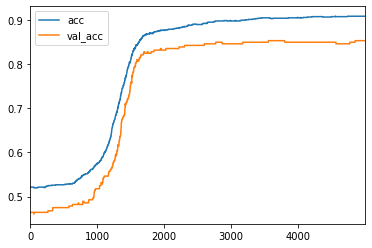

In [67]:
DataFrame({'acc': history.history['acc'], 
           'val_acc': history.history['val_acc']}).plot()

In [68]:
model.get_weights()

[array([[0.12603283],
        [0.1682104 ]], dtype=float32), array([-4.3192987], dtype=float32)]

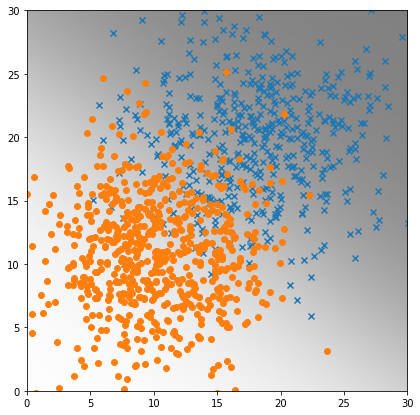

In [69]:
[[w1], [w2]], [b] = model.get_weights()

train_set0 = train_set[train_set['t'] == 0]
train_set1 = train_set[train_set['t'] == 1]

fig = plt.figure(figsize=(7,7))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_ylim([0, 30])
subplot.set_xlim([0, 30])
subplot.scatter(train_set1.x1, train_set1.x2, marker='x')
subplot.scatter(train_set0.x1, train_set0.x2, marker='o')

field = [
    [
        (1 / (1 + np.exp(-(w1*x1 + w2*x2 + b))))
        for x1 in np.linspace(0, 30, 100)
    ]
    for x2 in np.linspace(0, 30, 100)
]
subplot.imshow(field, origin='lower', extent=(0, 30, 0, 30),
              vmin=0, vmax=1, cmap=plt.cm.gray_r, alpha=0.5)